In [14]:
%%capture

!pip install ultralytics
!pip install shapely
!pip install python-dotenv
#install important packages

In [15]:
import os
from dotenv import load_dotenv
 
from ultralytics import YOLO

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt

import numpy as np
from numpy import asarray
from PIL import Image, ImageDraw, ImageFont , ImageEnhance

import cv2

from shapely.geometry import Polygon
from inference_sdk import InferenceHTTPClient

from ChessTools import *
from computer_vision_tools import *


In [16]:
def order_points(pts):
    
    # order a list of 4 coordinates:
    # 0: top-left,
    # 1: top-right
    # 2: bottom-right,
    # 3: bottom-left
    
    if len(pts) < 4:
        raise ValueError("At least 4 points are required.")
    
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect




In [17]:
# calculates iou (intersection over union) between two polygons

def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

In [18]:
def detect_corners_API(image_Path,confidence=50):
    
    load_dotenv()
    api_key = os.getenv('ROBOFLOW_API_KEY')

    image = Image.open(image_Path)
    CLIENT = InferenceHTTPClient(
        api_url="https://detect.roboflow.com",
        api_key=api_key
    )
    
    result = CLIENT.infer(image, model_id=f"chessboard-detection-yqcnu/3?confidence={confidence}")
        
    # Extracting the x, y coordinates of each corner
    corners = [[prediction['x'], prediction['y']] for prediction in result['predictions']]
    return np.array(corners, dtype="float32")

def detect_corners_local(image_Path,confidence=50):
    
    model = YOLO("best_corner_detection_model.pt")
    
    
    # Run detection on the image
    results = model.predict(image_Path, conf=confidence/100)
    #print(results)
    # Access the first element of the results list
    first_result = results[0]
    
    for detection in results[0].boxes:  # Access the first result and iterate over each detected box
        # Extract corner coordinates
        x1, y1, x2, y2 = detection.xyxy[0]  # Bounding box coordinates
        # Extract confidence score
        conf_score = detection.conf[0]
        # Extract class label
        class_label = detection.cls[0]

        #print(f"Corner detected at ({x1:.2f}, {y1:.2f}), ({x2:.2f}, {y2:.2f}) with confidence {conf_score:.2f} and label {class_label}")
        
    if first_result.boxes is not None:
        corners = [[(boxes[0] + boxes[2])/2,(boxes[1] + boxes[3])/2] for boxes in first_result.boxes.xyxy.cpu().numpy()]
        #print(corners)
        corners = corners[:4]
        
    else:
        corners = np.array([])  # If no corners are detected, return an empty array
    

    return np.array(corners, dtype="float32")


  

In [19]:
#perspective transforms an image with four given corners

def four_point_transform(image, pts,additional_height = 0):

    img = Image.open(image)
    #img.show()
    image = asarray(img)
    rect = order_points(pts)
    
    rect[0][1] = rect[0][1] - additional_height
    rect[1][1] = rect[1][1] - additional_height


    (tl, tr, br, bl) = rect

    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))


    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2)) 
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2)) 
    maxHeight = max(int(heightA), int(heightB))

    # construct set of destination points to obtain a "birds eye view"
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    img = Image.fromarray(warped, "RGB")
    #img.show()    
    # return the warped image
    img.save("transformer_image.jpg")
    return img


In [20]:
# calculates chessboard grid

def plot_grid_on_transformed_image(image,additional_height = 0):
    
    corners = np.array([[0,0], 
                    [image.size[0], 0], 
                    [0, image.size[1]], 
                    [image.size[0], image.size[1]]])
    
    corners = order_points(corners)

    figure(figsize=(10, 10), dpi=80)

    # im = plt.imread(image)
    implot = plt.imshow(image)
    
    TL = corners[0]
    BL = corners[3]
    TR = corners[1]
    BR = corners[2]

    def interpolate(xy0, xy1):
        x0,y0 = xy0
        x1,y1 = xy1
        dx = (x1-x0) / 8
        dy = (y1-y0) / 8
        pts = [(x0+i*dx,y0+i*dy) for i in range(9)]
        return pts
    
    def interpolate_with_extra_height(xy0, xy1, height):
        x0,y0 = xy0
        x1,y1 = xy1
        dx = (x1-x0) / 8
        dy = (y1-height-y0) / 8
        pts = [(x0+i*dx,y0+i*dy + (i!=0)*height) for i in range(9)]
        return pts

    ptsT = interpolate( TL, TR )
    ptsL = interpolate_with_extra_height( TL, BL, additional_height )
    ptsR = interpolate_with_extra_height( TR, BR, additional_height )
    ptsB = interpolate( BL, BR )
        
    for a,b in zip(ptsL, ptsR):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
    for a,b in zip(ptsT, ptsB):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
        
    plt.axis('off')

    plt.savefig('chessboard_transformed_with_grid.jpg')
    return ptsT, ptsL

In [21]:
# detects chess pieces

def chess_pieces_detector_API(image):
    
    # model_trained = YOLO("best_transformed_detection.pt")
    # results = model_trained.predict(source=image, line_thickness=1, conf=0.5, augment=False, save_txt=True, save=True)
    # 
    # print("results\n",results)
    # 
    # boxes = results[0].boxes
    # detections = boxes.xyxy.numpy()
    
    load_dotenv()
    api_key = os.getenv('ROBOFLOW_API_KEY')
    
    CLIENT = InferenceHTTPClient(
        api_url="https://detect.roboflow.com",
        api_key=api_key
    )
    
    result = CLIENT.infer(image, model_id="sp2-ym1iq-9on5y/1")
    
    boxes = [i["class_id"] for i in result["predictions"]]
    
    detections = [[i["x"]-i["width"]/2,i["y"]-i["height"]/2,i["x"]+i["width"]/2,i["y"]+i["height"]/2] for i in result["predictions"]]
    detections = np.array(detections,dtype="float32")
        
    return detections, boxes

def chess_pieces_detector_local(image,confidence = 50):
    
    model = YOLO("best_chesspiece_model.pt")
    
    
    # Run detection on the image
    results = model.predict("transformer_image.jpg", conf=confidence/100)
    
    # Access the first element of the results list
    first_result = results[0]
            
    boxes = [int(box.cls[0].item()) for box in first_result.boxes]
    detections = [box.xyxy[0].tolist() for box in first_result.boxes]
    
    return detections, boxes
        
    
    

In [22]:
    
def connect_detection_to_square(squares,detection_box):
    list_of_iou = []
    
    box_x1 = detection_box[0]
    box_y1 = detection_box[1]

    box_x2 = detection_box[2]
    box_y2 = detection_box[1]

    box_x3 = detection_box[2]
    box_y3 = detection_box[3]

    box_x4 = detection_box[0]
    box_y4 = detection_box[3]
    
    #cut high pieces        
    if box_y4 - box_y1 > 60:
        box_complete = np.array([[box_x1,box_y1+40], [box_x2, box_y2+40], [box_x3, box_y3], [box_x4, box_y4]])
    else:
        box_complete = np.array([[box_x1,box_y1], [box_x2, box_y2], [box_x3, box_y3], [box_x4, box_y4]])
        
    for i in range (8):
        for j in range (8):
            list_of_iou.append(calculate_iou(box_complete, squares[i][j]))
    num = list_of_iou.index(max(list_of_iou))
    
    return num//8,num%8 #returns the position of the square that matches the piece detection the most

In [23]:
def FEN_transformation(ptsT,ptsL,detections,boxes):
    #calculate the grid
    
    xA = ptsT[0][0]
    xB = ptsT[1][0]
    xC = ptsT[2][0]
    xD = ptsT[3][0]
    xE = ptsT[4][0]
    xF = ptsT[5][0]
    xG = ptsT[6][0]
    xH = ptsT[7][0]
    xI = ptsT[8][0]
    
    y9 = ptsL[0][1]
    y8 = ptsL[1][1] 
    y7 = ptsL[2][1] 
    y6 = ptsL[3][1]  
    y5 = ptsL[4][1]  
    y4 = ptsL[5][1] 
    y3 = ptsL[6][1]  
    y2 = ptsL[7][1] 
    y1 = ptsL[8][1] 
    
    #calculate all the squares
    
    a8 = np.array([[xA,y9], [xB, y9], [xB, y8], [xA, y8]])
    a7 = np.array([[xA,y8], [xB, y8], [xB, y7], [xA, y7]])
    a6 = np.array([[xA,y7], [xB, y7], [xB, y6], [xA, y6]])
    a5 = np.array([[xA,y6], [xB, y6], [xB, y5], [xA, y5]])
    a4 = np.array([[xA,y5], [xB, y5], [xB, y4], [xA, y4]])
    a3 = np.array([[xA,y4], [xB, y4], [xB, y3], [xA, y3]])
    a2 = np.array([[xA,y3], [xB, y3], [xB, y2], [xA, y2]])
    a1 = np.array([[xA,y2], [xB, y2], [xB, y1], [xA, y1]])
    
    b8 = np.array([[xB,y9], [xC, y9], [xC, y8], [xB, y8]])
    b7 = np.array([[xB,y8], [xC, y8], [xC, y7], [xB, y7]])
    b6 = np.array([[xB,y7], [xC, y7], [xC, y6], [xB, y6]])
    b5 = np.array([[xB,y6], [xC, y6], [xC, y5], [xB, y5]])
    b4 = np.array([[xB,y5], [xC, y5], [xC, y4], [xB, y4]])
    b3 = np.array([[xB,y4], [xC, y4], [xC, y3], [xB, y3]])
    b2 = np.array([[xB,y3], [xC, y3], [xC, y2], [xB, y2]])
    b1 = np.array([[xB,y2], [xC, y2], [xC, y1], [xB, y1]])
    
    c8 = np.array([[xC,y9], [xD, y9], [xD, y8], [xC, y8]])
    c7 = np.array([[xC,y8], [xD, y8], [xD, y7], [xC, y7]])
    c6 = np.array([[xC,y7], [xD, y7], [xD, y6], [xC, y6]])
    c5 = np.array([[xC,y6], [xD, y6], [xD, y5], [xC, y5]])
    c4 = np.array([[xC,y5], [xD, y5], [xD, y4], [xC, y4]])
    c3 = np.array([[xC,y4], [xD, y4], [xD, y3], [xC, y3]])
    c2 = np.array([[xC,y3], [xD, y3], [xD, y2], [xC, y2]])
    c1 = np.array([[xC,y2], [xD, y2], [xD, y1], [xC, y1]])
    
    d8 = np.array([[xD,y9], [xE, y9], [xE, y8], [xD, y8]])
    d7 = np.array([[xD,y8], [xE, y8], [xE, y7], [xD, y7]])
    d6 = np.array([[xD,y7], [xE, y7], [xE, y6], [xD, y6]])
    d5 = np.array([[xD,y6], [xE, y6], [xE, y5], [xD, y5]])
    d4 = np.array([[xD,y5], [xE, y5], [xE, y4], [xD, y4]])
    d3 = np.array([[xD,y4], [xE, y4], [xE, y3], [xD, y3]])
    d2 = np.array([[xD,y3], [xE, y3], [xE, y2], [xD, y2]])
    d1 = np.array([[xD,y2], [xE, y2], [xE, y1], [xD, y1]])
    
    e8 = np.array([[xE,y9], [xF, y9], [xF, y8], [xE, y8]])
    e7 = np.array([[xE,y8], [xF, y8], [xF, y7], [xE, y7]])
    e6 = np.array([[xE,y7], [xF, y7], [xF, y6], [xE, y6]])
    e5 = np.array([[xE,y6], [xF, y6], [xF, y5], [xE, y5]])
    e4 = np.array([[xE,y5], [xF, y5], [xF, y4], [xE, y4]])
    e3 = np.array([[xE,y4], [xF, y4], [xF, y3], [xE, y3]])
    e2 = np.array([[xE,y3], [xF, y3], [xF, y2], [xE, y2]])
    e1 = np.array([[xE,y2], [xF, y2], [xF, y1], [xE, y1]])
    
    f8 = np.array([[xF,y9], [xG, y9], [xG, y8], [xF, y8]])
    f7 = np.array([[xF,y8], [xG, y8], [xG, y7], [xF, y7]])
    f6 = np.array([[xF,y7], [xG, y7], [xG, y6], [xF, y6]])
    f5 = np.array([[xF,y6], [xG, y6], [xG, y5], [xF, y5]])
    f4 = np.array([[xF,y5], [xG, y5], [xG, y4], [xF, y4]])
    f3 = np.array([[xF,y4], [xG, y4], [xG, y3], [xF, y3]])
    f2 = np.array([[xF,y3], [xG, y3], [xG, y2], [xF, y2]])
    f1 = np.array([[xF,y2], [xG, y2], [xG, y1], [xF, y1]])
    
    g8 = np.array([[xG,y9], [xH, y9], [xH, y8], [xG, y8]])
    g7 = np.array([[xG,y8], [xH, y8], [xH, y7], [xG, y7]])
    g6 = np.array([[xG,y7], [xH, y7], [xH, y6], [xG, y6]])
    g5 = np.array([[xG,y6], [xH, y6], [xH, y5], [xG, y5]])
    g4 = np.array([[xG,y5], [xH, y5], [xH, y4], [xG, y4]])
    g3 = np.array([[xG,y4], [xH, y4], [xH, y3], [xG, y3]])
    g2 = np.array([[xG,y3], [xH, y3], [xH, y2], [xG, y2]])
    g1 = np.array([[xG,y2], [xH, y2], [xH, y1], [xG, y1]])
    
    h8 = np.array([[xH,y9], [xI, y9], [xI, y8], [xH, y8]])
    h7 = np.array([[xH,y8], [xI, y8], [xI, y7], [xH, y7]])
    h6 = np.array([[xH,y7], [xI, y7], [xI, y6], [xH, y6]])
    h5 = np.array([[xH,y6], [xI, y6], [xI, y5], [xH, y5]])
    h4 = np.array([[xH,y5], [xI, y5], [xI, y4], [xH, y4]])
    h3 = np.array([[xH,y4], [xI, y4], [xI, y3], [xH, y3]])
    h2 = np.array([[xH,y3], [xI, y3], [xI, y2], [xH, y2]])
    h1 = np.array([[xH,y2], [xI, y2], [xI, y1], [xH, y1]])
    
    # transforms the squares to write FEN
    
    FEN_annotation = [[a8, b8, c8, d8, e8, f8, g8, h8],
                    [a7, b7, c7, d7, e7, f7, g7, h7],
                    [a6, b6, c6, d6, e6, f6, g6, h6],
                    [a5, b5, c5, d5, e5, f5, g5, h5],
                    [a4, b4, c4, d4, e4, f4, g4, h4],
                    [a3, b3, c3, d3, e3, f3, g3, h3],
                    [a2, b2, c2, d2, e2, f2, g2, h2],
                    [a1, b1, c1, d1, e1, f1, g1, h1]]
    
    board_FEN = [['1' for i in range(8)] for j in range(8)]
    
    di = {0: 'b', 1: 'k', 2: 'n',
      3: 'p', 4: 'q', 5: 'r', 
      6: 'B', 7: 'K', 8: 'N',
      9: 'P', 10: 'Q', 11: 'R'}
    
    for piece_number, detection_box in zip(boxes,detections):
        i, j = connect_detection_to_square(FEN_annotation,detection_box)
        board_FEN[i][j] = di[piece_number]
        
    print(board_FEN)
    complete_board_FEN = [''.join(line) for line in board_FEN] 
    return complete_board_FEN

In [24]:
def make_black_spots_blacker(image_path, output_path, threshold=50):
    """
    Enhances the black spots/pieces in the image by making them darker.
    
    Parameters:
    - image_path: Path to the input image.
    - output_path: Path to save the output image.
    - threshold: Grayscale intensity below which pixels are considered "dark" (0-255).
    """
    # Open the image
    img = Image.open(image_path).convert("RGB")
    
    # Convert to grayscale to identify dark areas
    grayscale = img.convert("L")
    
    # Create a mask for dark areas
    mask = grayscale.point(lambda p: 255 if p < threshold else 0, mode="1")
    
    # Darken the black spots
    darkened = img.point(lambda p: p * 0.5 if p < threshold else p)
    
    # Combine the darkened areas with the original image
    img = Image.composite(darkened, img, mask)
    
    # Save the modified image
    img.save(output_path)
    print(f"Image saved to {output_path}")

## Complete

In [25]:

image_Path = 'images/image3.jpg'

#additionnal height is added based on the angle the picture was taken so that the top pieaces won't be cropped (height in pixels) 
additional_height = 50

corners = detect_corners_API(image_Path,9)

transformed_image = four_point_transform(image_Path, corners,additional_height)

ptsT, ptsL = plot_grid_on_transformed_image(transformed_image,additional_height)

detections, boxes = chess_pieces_detector_API(transformed_image)

complete_board_FEN = FEN_transformation(ptsT,ptsL,detections,boxes)

to_FEN = '/'.join(complete_board_FEN)

lichess_URL = "https://lichess.org/analysis/"+to_FEN

print(lichess_URL)

print(to_FEN)
print_board_from_fen(compress_fen(to_FEN))



SyntaxError: invalid syntax (3219162965.py, line 25)

image 1/1 C:\Users\rayen\OneDriveRayen\Desktop\Rayen\projects\ChessBoardDetectionv1\images\image11.jpg: 512x640 7 chess-table-cornerss, 83.6ms
Speed: 2.0ms preprocess, 83.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)
Image saved to transformer_image.jpg
image 1/1 C:\Users\rayen\OneDriveRayen\Desktop\Rayen\projects\ChessBoardDetectionv1\transformer_image.jpg: 544x640 2 black-bishops, 1 black-king, 2 black-knights, 8 black-pawns, 2 black-queens, 2 black-rooks, 4 white-bishops, 2 white-knights, 8 white-pawns, 1 white-queen, 2 white-rooks, 92.1ms
Speed: 3.0ms preprocess, 92.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)
[['r', 'n', 'b', 'q', 'q', 'b', 'n', 'r'], ['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p'], ['1', '1', '1', '1', '1', '1', '1', '1'], ['1', '1', '1', '1', '1', '1', '1', '1'], ['1', '1', '1', '1', '1', '1', '1', '1'], ['1', '1', '1', '1', '1', '1', '1', '1'], ['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P'], ['R', 'N', 'B', 'Q', 'B', 'B', 'N', 

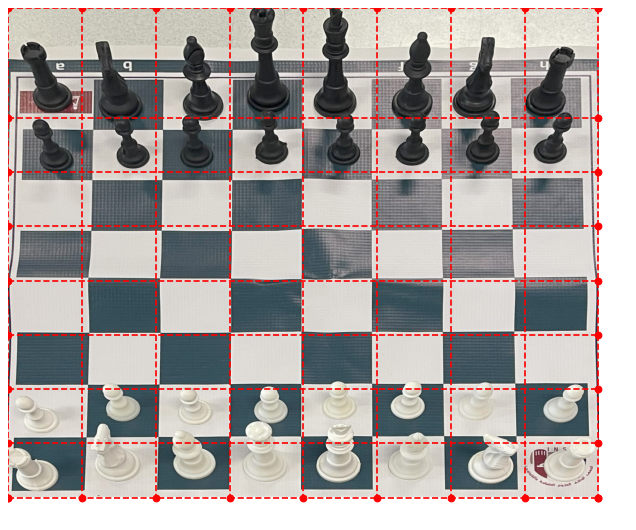

In [41]:
image_number = 11
image_Path = f'images/image{image_number}.jpg'

#additionnal height is added based on the angle the picture was taken so that the top pieaces won't be cropped (height in pixels) 
additional_height = 200

corners = detect_corners_local(image_Path,confidence=9)

transformed_image = four_point_transform(image_Path, corners,additional_height)

ptsT, ptsL = plot_grid_on_transformed_image(transformed_image,additional_height)

make_black_spots_blacker("transformer_image.jpg","transformer_image.jpg",80)

detections, boxes =chess_pieces_detector_local(transformed_image,40)

complete_board_FEN = FEN_transformation(ptsT,ptsL,detections,boxes)

to_FEN = '/'.join(complete_board_FEN)

lichess_URL = "https://lichess.org/analysis/"+to_FEN

print(lichess_URL)


print(to_FEN)
print_board_from_fen(compress_fen(to_FEN))


In [42]:
past_fen = "rnbqkbnr/pppppppp/11111111/11111111/11111111/11111111/PPPPPPPP/RNBQKBNR"
to_FEN = fix_queen_king_issue(past_fen,to_FEN)

print(to_FEN)
print_board_from_fen(compress_fen(to_FEN))

rnbqkbnr/pppppppp/11111111/11111111/11111111/11111111/PPPPPPPP/RNBQKBNR
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


[[(0, 70), (10, 70), (20, 70), (30, 70), (40, 70), (50, 70), (60, 70), (70, 70)], [(0, 60), (10, 60), (20, 60), (30, 60), (40, 60), (50, 60), (60, 60), (70, 60)], [(0, 50), (10, 50), (20, 50), (30, 50), (40, 50), (50, 50), (60, 50), (70, 50)], [(0, 40), (10, 40), (20, 40), (30, 40), (40, 40), (50, 40), (60, 40), (70, 40)], [(0, 30), (10, 30), (20, 30), (30, 30), (40, 30), (50, 30), (60, 30), (70, 30)], [(0, 20), (10, 20), (20, 20), (30, 20), (40, 20), (50, 20), (60, 20), (70, 20)], [(0, 10), (10, 10), (20, 10), (30, 10), (40, 10), (50, 10), (60, 10), (70, 10)], [(0, 0), (10, 0), (20, 0), (30, 0), (40, 0), (50, 0), (60, 0), (70, 0)]]
